In [1]:
%pip install pmdarima
%pip install statsmodels
%pip install pyramid
%pip install pyramid-arima

import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached pyramid-arima-0.8.1.tar.gz (515 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for pyramid-arima
Failed to build pyramid-arima
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [19 lines of output]
      Partial import of pyramid during the build process.
      
      Requirements: ['Cython>=0.23\nnumpy>=1.10\nscipy>=0.9\nscikit-learn>=0.17\npandas>=0.19\nstatsmodels>=0.9.0\n']
      Adding extra setuptools args
      Traceback (most recent call last):
        File "C:\Users\Admin\AppData\Local\Temp\pip-install-zpbgcyzn\pyramid-arima_047f579d2cb845e7bc5bc5ba9dea2f8b\setup.py", line 225, in do_setup
          from numpy.distutils.core import setup
      ModuleNotFoundError: No module named 'numpy.distutils'
      
      During handling of the above exception, another exception occurred:
      
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\Admin\AppData\Local\Temp\pip-install-zpbgcyzn\pyramid-arima_047f579d2cb845e7bc5bc

In [2]:
SecurityName="NEPSE"
timeFrame='1D'

#model_data\NEPSE\1D\NEPSE_1D.csv, relative path is this,

current_directory = os.getcwd()

# Move one folder up from the current directory
parent_directory = os.path.dirname(current_directory)

# Move inside the model_data directory
folder_name = os.path.join(parent_directory, "model_data", SecurityName, timeFrame)
csv_path = os.path.join(folder_name, f"{SecurityName}_{timeFrame}.csv")

# folder_name = os.path.join(os.path.dirname(os.path.dirname(__file__)), "model_data", f"{SecurityName}", f"{timeFrame}")
# csv_path = os.path.join(folder_name, f"{SecurityName}_{timeFrame}.csv")

#df = pd.read_csv(csv_path)

stock_data = pd.read_csv(
    csv_path,
    sep=',',
    index_col='date',
    parse_dates=['date'],
    date_parser=lambda dates: pd.to_datetime(dates, format='%Y-%m-%d')  ).fillna(0)

stock_data.columns = stock_data.columns.str.capitalize()

stock_data

,Open,High,Low,Close,Volume
date,,,,,
2003-07-17,204.41,204.4100,204.4100,204.41,0.000000e+00
2003-07-18,204.31,204.3100,204.3100,204.31,0.000000e+00
2003-07-21,203.69,203.6900,203.6900,203.69,0.000000e+00
2003-07-22,203.56,203.5600,203.5600,203.56,0.000000e+00
2003-07-23,203.54,203.5400,203.5400,203.54,0.000000e+00
...,...,...,...,...,...
2024-06-02,2073.06,2086.4444,2068.0816,2083.04,4.310095e+09
2024-06-03,2087.80,2096.5725,2073.0267,2079.07,4.003299e+09
2024-06-04,2087.03,2092.7111,2077.5665,2085.30,4.083831e+09


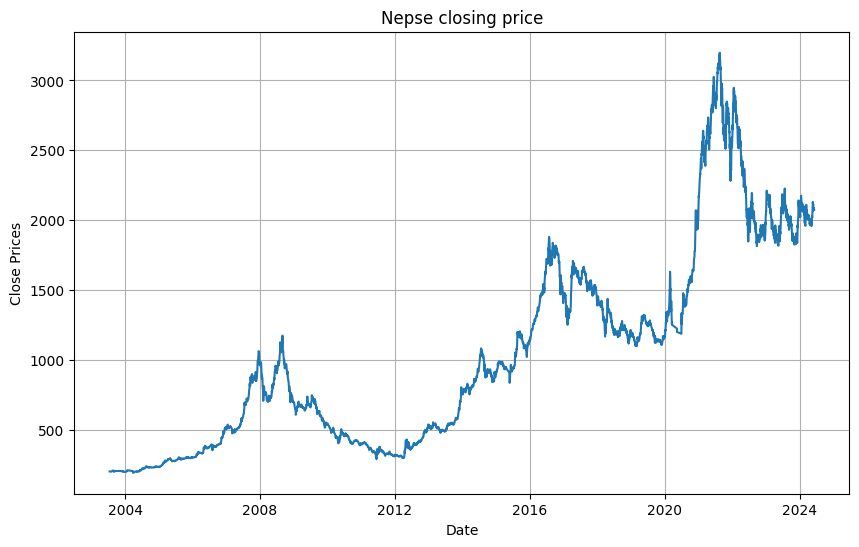

In [3]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('Nepse closing price')
plt.show()

<Axes: ylabel='Density'>

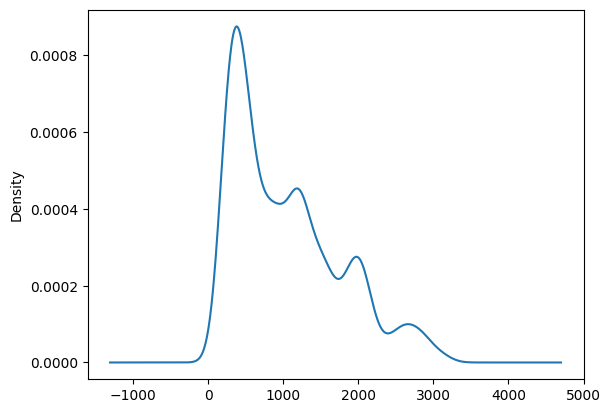

In [4]:
df_close = stock_data['Close']
df_close.plot(kind='kde')

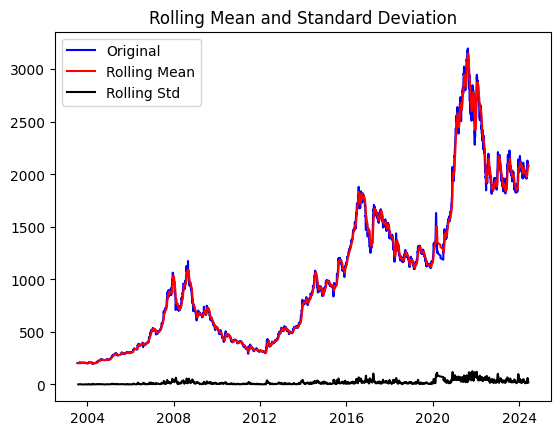

Results of dickey fuller test
Test Statistics                  -0.906586
p-value                           0.785796
No. of lags used                 28.000000
Number of observations used    4782.000000
critical value (1%)              -3.431718
critical value (5%)              -2.862145
critical value (10%)             -2.567092
dtype: float64


In [5]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

<Axes: ylabel='Density'>

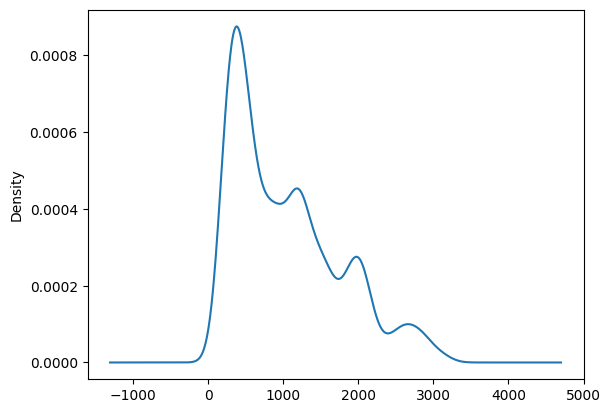

In [6]:
df_close = stock_data['Close']
df_close.plot(kind='kde')

<Figure size 640x480 with 0 Axes>

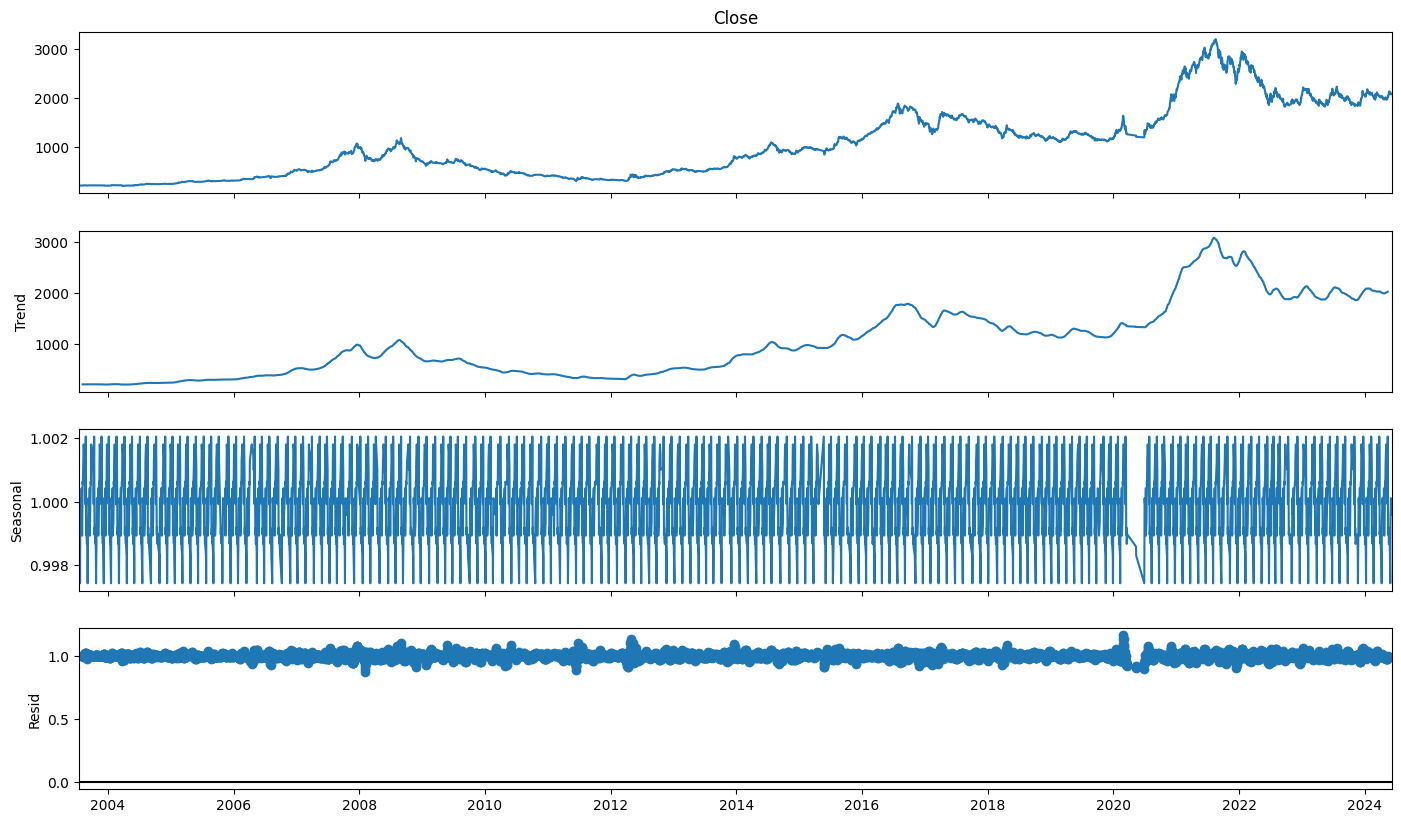

In [7]:
result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

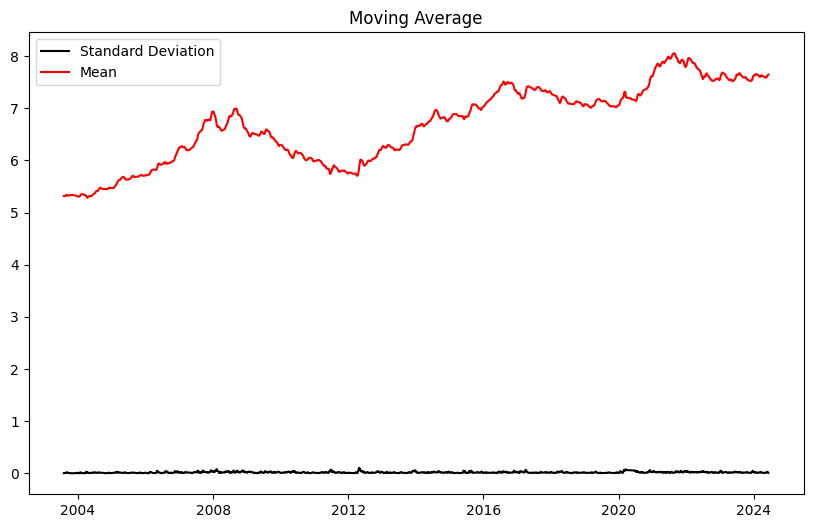

In [8]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

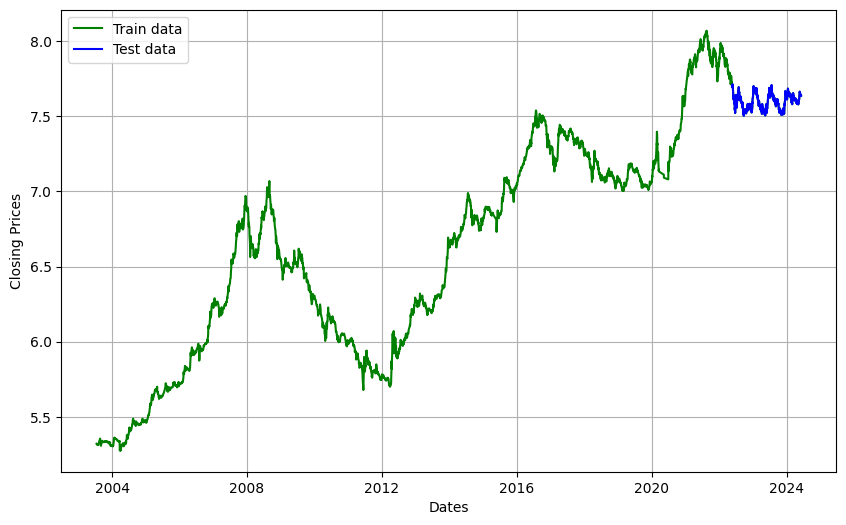

In [9]:
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-25585.821, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-25821.270, Time=0.39 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-25851.440, Time=1.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-25579.413, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-25851.023, Time=0.47 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-25851.619, Time=1.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-25848.676, Time=1.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-25850.651, Time=0.85 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-25815.279, Time=1.97 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-25847.718, Time=0.24 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 7.548 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4326
Model:               SARIMAX(0, 1, 2)   Lo

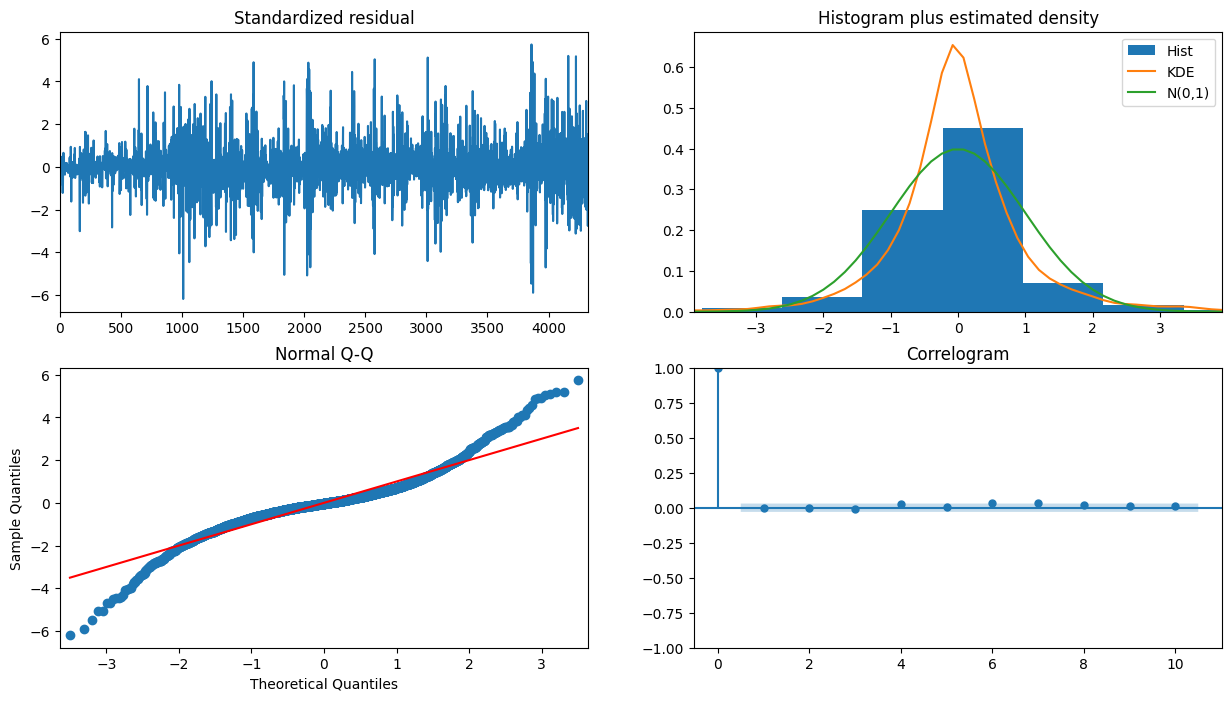

In [10]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [14]:
%pip install --upgrade pip setuptools
%pip install --upgrade numpy scipy
%pip install numpy
%pip install pyramid-arima


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached pyramid-arima-0.8.1.tar.gz (515 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for pyramid-arima
Failed to build pyramid-arima
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [19 lines of output]
      Partial import of pyramid during the build process.
      
      Requirements: ['Cython>=0.23\nnumpy>=1.10\nscipy>=0.9\nscikit-learn>=0.17\npandas>=0.19\nstatsmodels>=0.9.0\n']
      Adding extra setuptools args
      Traceback (most recent call last):
        File "C:\Users\Admin\AppData\Local\Temp\pip-install-ted3eioy\pyramid-arima_478c6356faff4a92954bbee91d126aa1\setup.py", line 225, in do_setup
          from numpy.distutils.core import setup
      ModuleNotFoundError: No module named 'numpy.distutils'
      
      During handling of the above exception, another exception occurred:
      
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\Admin\AppData\Local\Temp\pip-install-ted3eioy\pyramid-arima_478c6356faff4a92954bb

In [12]:
from pyramid.arima import auto_arima
model = auto_arima(train_data, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)

# model = ARIMA(train_data, order=(0,1,2))
# fitted = model.fit(disp=-1) # fit model model.fit(disp=-1)
print(fitted.summary())

ModuleNotFoundError: No module named 'pyramid.arima'

In [ ]:
#Let’s now begin forecasting stock prices on the test dataset with a 95% confidence level.
#fc, se, conf = fitted.forecast(steps=321)  # 95% conf

fc, se, conf = fitted.forecast(321, alpha=0.05)


# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.10)
plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

KeyError: (slice(None, None, None), 0)